# Predicting PM2.5 Concentration: Linear Regression vs Neural Network

In this notebook, we demonstrate how neural networks can outperform linear regression in modeling complex relationships. We use the Beijing Multi-Site Air-Quality dataset from the UCI Machine Learning Repository to predict PM2.5 concentration.

📊 Dataset: Beijing Multi-Site Air-Quality Data

🏢 Source:
Collected by the Beijing Municipal Environmental Monitoring Center.
Available through the UCI Machine Learning Repository.

📆 Time Period Covered:
March 1, 2013 to February 28, 2017
Hourly frequency

🗺️ Geographical Coverage:

Measurements taken from 6 monitoring stations in Beijing:

Aotizhongxin
Changping
Dingling
Dongsi
Guanyuan
Huairou
Each site includes meteorological and air-quality readings.

📦 Main Variables in the Dataset:

Column	Description
No	Row number (index)

year	Year of measurement

month	Month of measurement

day	Day of measurement

hour	Hour of measurement

pm2.5	PM2.5 concentration (μg/m³) — target variable

DEWP	Dew Point (°C)

TEMP	Temperature (°C)

PRES	Atmospheric pressure (hPa)

cbwd	Combined wind direction (categorical: NE, SE, NW, etc.)

Iws	Cumulated wind speed (m/s)

Is	Cumulated hours of snow

Ir	Cumulated hours of rain

station	Monitoring station name (optional — could be dropped)

🎯 Prediction Goal:
You are using this dataset to predict hourly PM2.5 concentration, a fine particulate matter that significantly affects air quality and human health.

📌 Why It’s Interesting for ML:
Time series + environmental: complex dependencies between features.
Nonlinear: weather and pollution don't have linear effects on PM2.5.
Imbalanced: pollution spikes are rare but critical.
Multisite data: station differences introduce heterogeneity.

## 📦 1. Install and Import Required Libraries

We start by installing the `ucimlrepo` package to fetch the dataset, and import all necessary libraries for data processing and modeling.


In [ ]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from ucimlrepo import fetch_ucirepo


## 📂 2. Load the Beijing Air Quality Dataset

We load the dataset (UCI ID 381) which contains meteorological and air pollution data from multiple sites in Beijing.
https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data


📊 Plot: Correlation Heatmap of Features vs PM2.5

<ipython-input-34-fdd8d14d600b>:26: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


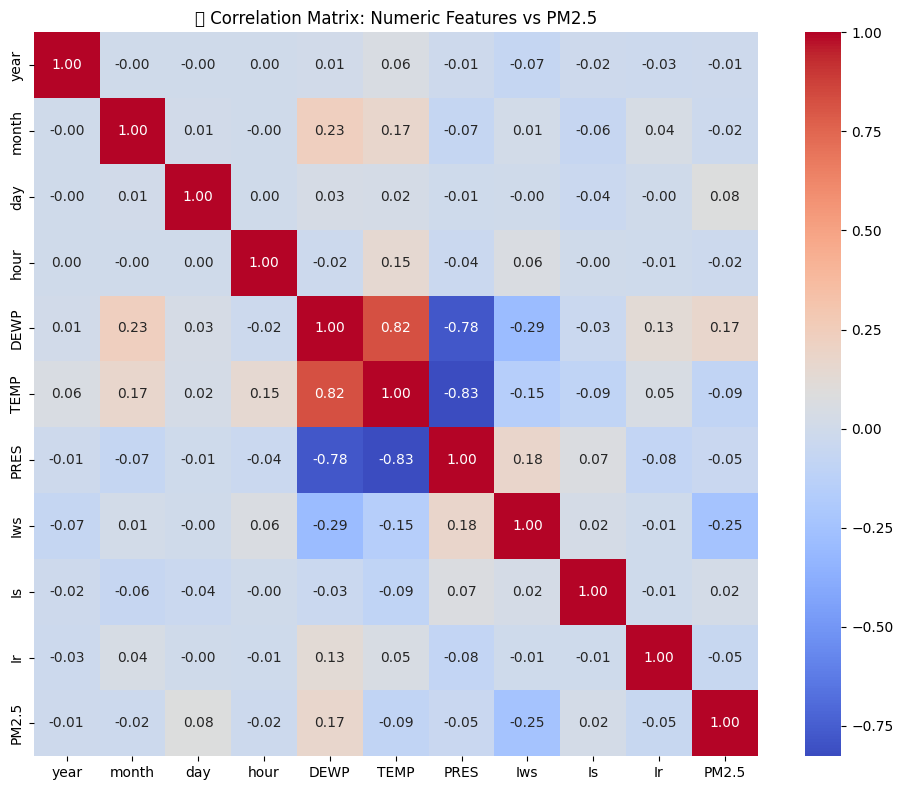

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# Load the dataset
df = fetch_ucirepo(id=381)
X = df.data.features
y = df.data.targets

# Combine features and target for visualization
data_viz = X.copy()
data_viz['PM2.5'] = y.values

# Drop rows with missing PM2.5
data_viz = data_viz.dropna(subset=['PM2.5'])

# Keep only numeric columns for correlation
numeric_data = data_viz.select_dtypes(include=[np.number])

# Plot correlation matrix
plt.figure(figsize=(10, 8))
corr = numeric_data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("🔗 Correlation Matrix: Numeric Features vs PM2.5")
plt.tight_layout()
plt.show()


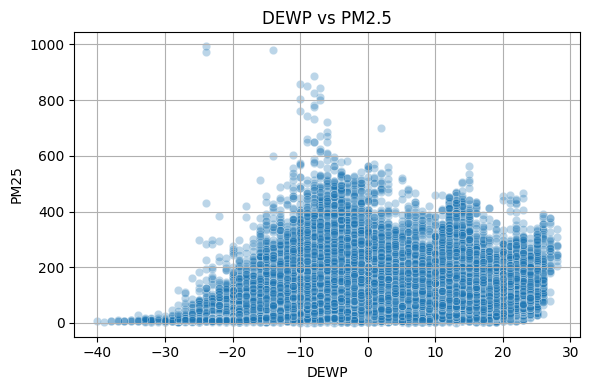

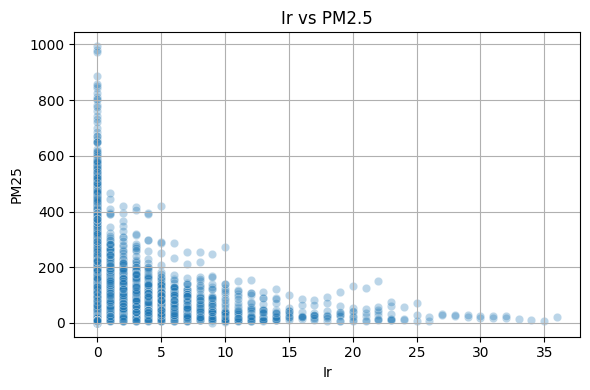

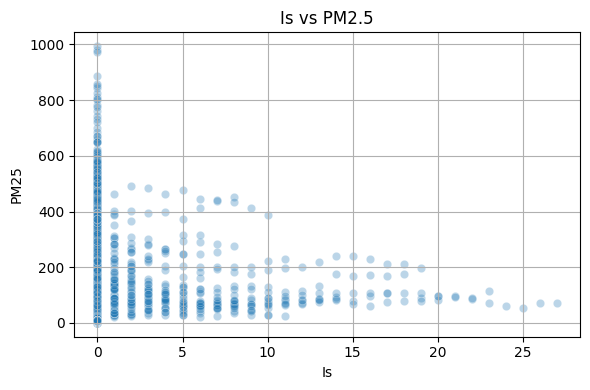

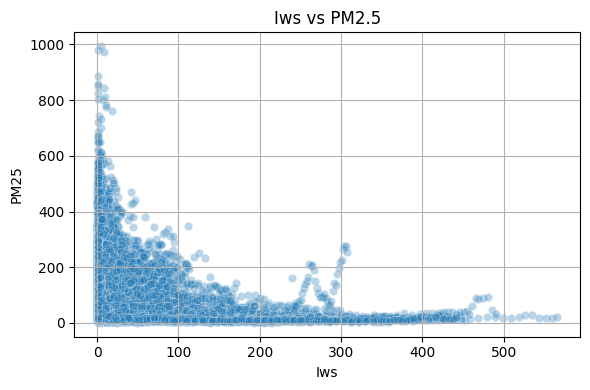

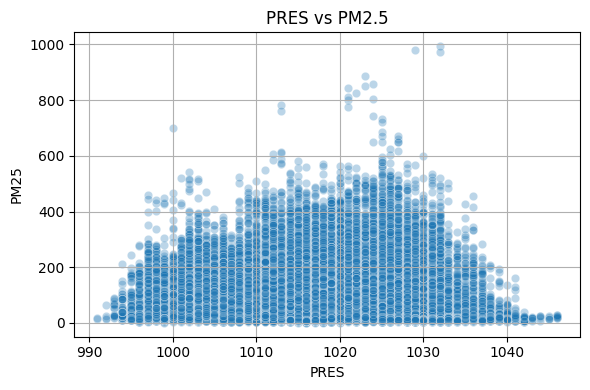

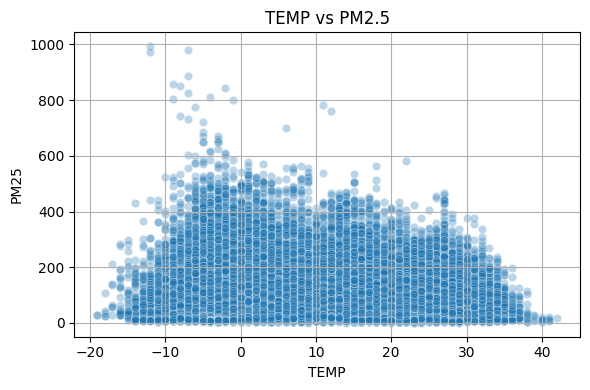

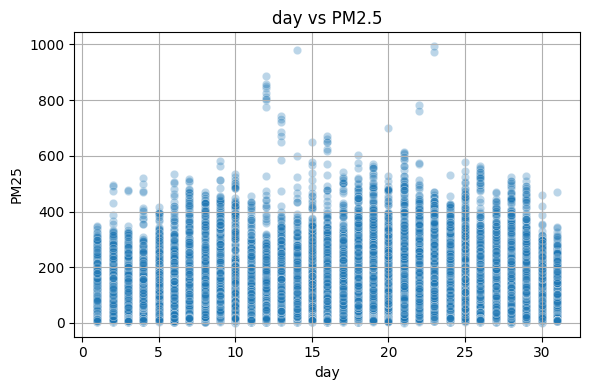

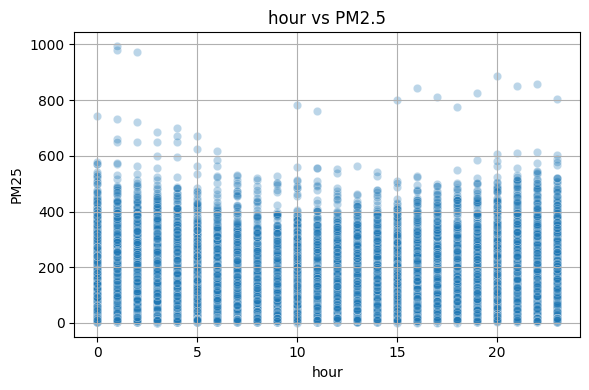

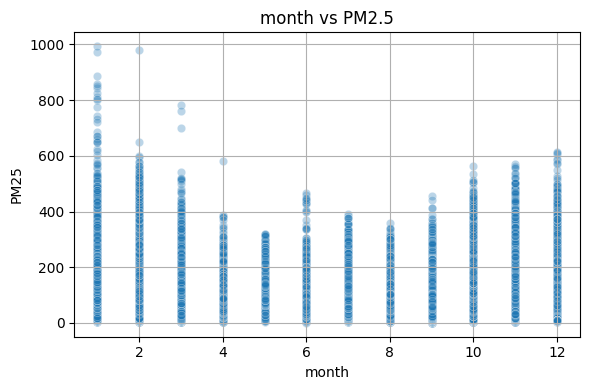

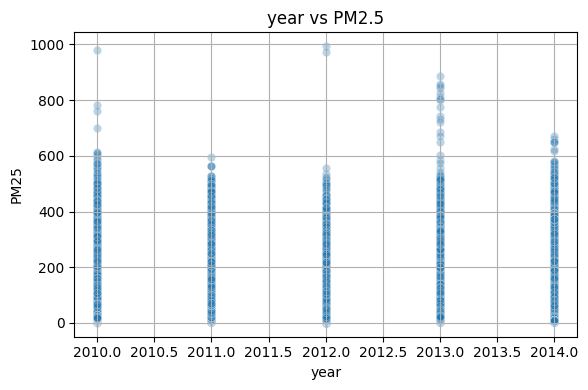

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a temporary DataFrame with clean target column
data_plot = X.copy()
data_plot['PM25'] = y.values  # Clean name for easier plotting

# Plot feature vs target for each numerical variable
for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=data_plot, x=col, y='PM25', alpha=0.3)
    plt.title(f"{col} vs PM2.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


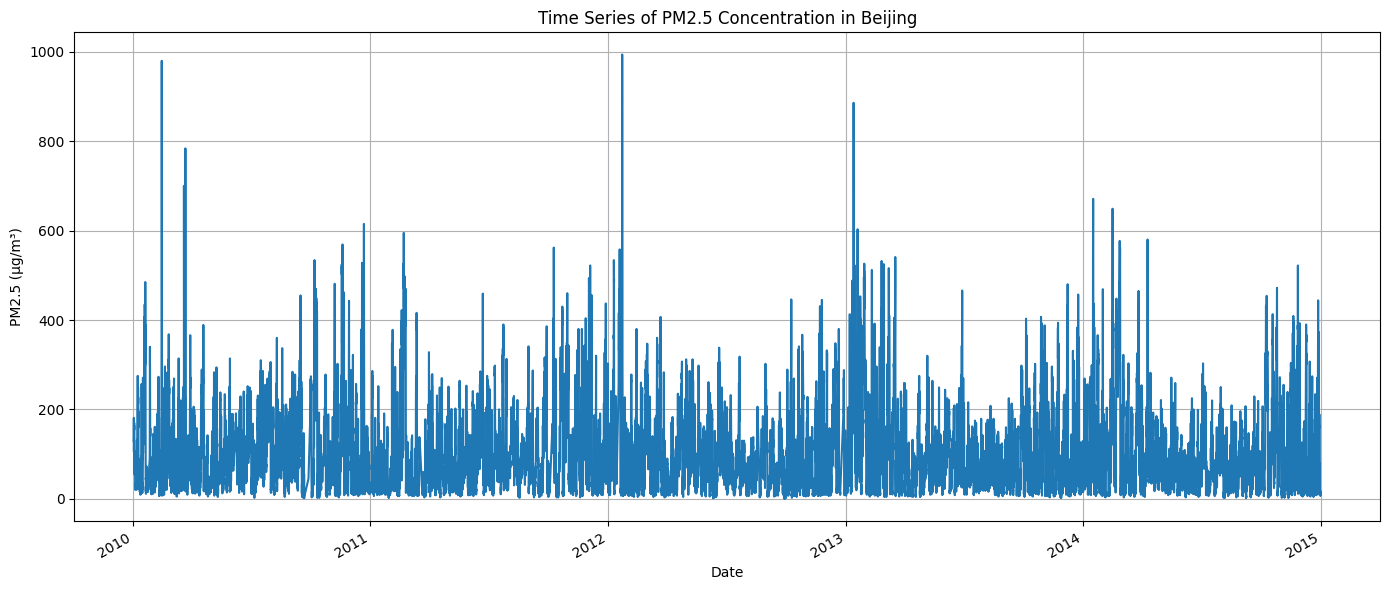

In [ ]:


# Combine features and target
data_viz = X.copy()
data_viz['PM2.5'] = y.values

# Drop rows with missing PM2.5
data_viz = data_viz.dropna(subset=['PM2.5'])

# Create datetime index
datetime = pd.to_datetime(data_viz[['year', 'month', 'day', 'hour']])
data_viz.index = datetime

# Plot the PM2.5 time series
plt.figure(figsize=(14, 6))
data_viz['PM2.5'].sort_index().plot()
plt.title("Time Series of PM2.5 Concentration in Beijing")
plt.ylabel("PM2.5 (μg/m³)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 3. Identify and Preprocess Features

We separate numerical and categorical features, apply imputers for missing values, and scale/encode them accordingly.


In [ ]:
categorical_features = ['cbwd']
numerical_features = X.columns.difference(categorical_features)

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)])


## ✂️ 4. Train-Test Split and Clean Target Data

We split the dataset into training and testing sets and remove missing values from the target (`PM2.5`) to avoid training errors.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("Linear Regression Results:")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")




Linear Regression Results:
R² Score: 0.2730
RMSE: 77.8271


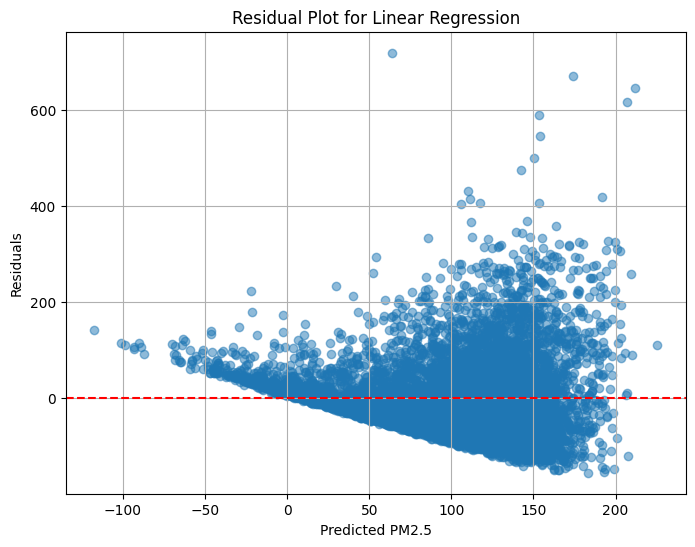

In [ ]:
# prompt: plot residuals

import matplotlib.pyplot as plt
residuals = y_test - y_pred_lr

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residuals")
plt.title("Residual Plot for Linear Regression")
plt.grid(True)
plt.show()


## 🧠 6. Neural Network Model

Now we train a feedforward neural network with two hidden layers using `MLPRegressor`, again within a pipeline.


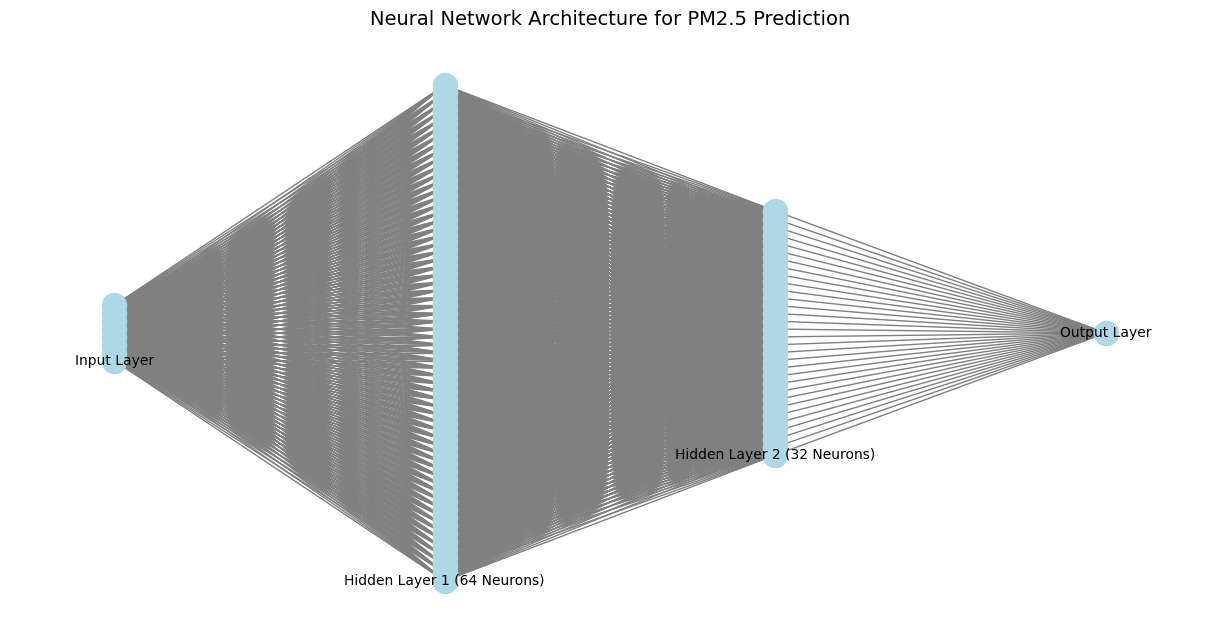

In [ ]:
!pip install networkx


import matplotlib.pyplot as plt
import networkx as nx

# Define the architecture layers
layers = {
    "Input Layer": 8,  # Assume 8 input features after preprocessing
    "Hidden Layer 1 (64 Neurons)": 64,
    "Hidden Layer 2 (32 Neurons)": 32,
    "Output Layer": 1
}

# Create the graph
G = nx.DiGraph()

# Add nodes layer by layer
positions = {}
labels = {}
layer_spacing = 2
node_spacing = 1

x = 0
for layer_name, num_nodes in layers.items():
    y_start = -(num_nodes - 1) / 2
    for i in range(num_nodes):
        node_id = f"{layer_name}_{i}"
        G.add_node(node_id)
        positions[node_id] = (x, y_start + i * node_spacing)
        if i == 0:
            labels[node_id] = layer_name  # Label only one node per layer for clarity
    x += layer_spacing

# Add edges between all nodes in consecutive layers
layer_names = list(layers.keys())
for i in range(len(layer_names) - 1):
    current_layer = layer_names[i]
    next_layer = layer_names[i + 1]
    for n1 in range(layers[current_layer]):
        for n2 in range(layers[next_layer]):
            G.add_edge(f"{current_layer}_{n1}", f"{next_layer}_{n2}")

# Plot




plt.figure(figsize=(12, 6))
nx.draw(G, pos=positions, with_labels=False, node_size=300, arrows=False, node_color="lightblue", edge_color="gray")
nx.draw_networkx_labels(G, pos=positions, labels=labels, font_size=10, verticalalignment='center')

plt.title("Neural Network Architecture for PM2.5 Prediction", fontsize=14)
plt.axis('off')

# Save as transparent PNG
plt.savefig("nn_architecture_pm25.png", transparent=True, dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(64, 32),
        max_iter=1000,
        early_stopping=True,
        random_state=42))
])

nn_pipeline.fit(X_train, y_train.values.ravel())
y_pred_nn = nn_pipeline.predict(X_test)

print("\nNeural Network Results:")
print(f"R² Score: {r2_score(y_test, y_pred_nn):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_nn)):.4f}")




Neural Network Results:
R² Score: 0.6464
RMSE: 54.2764


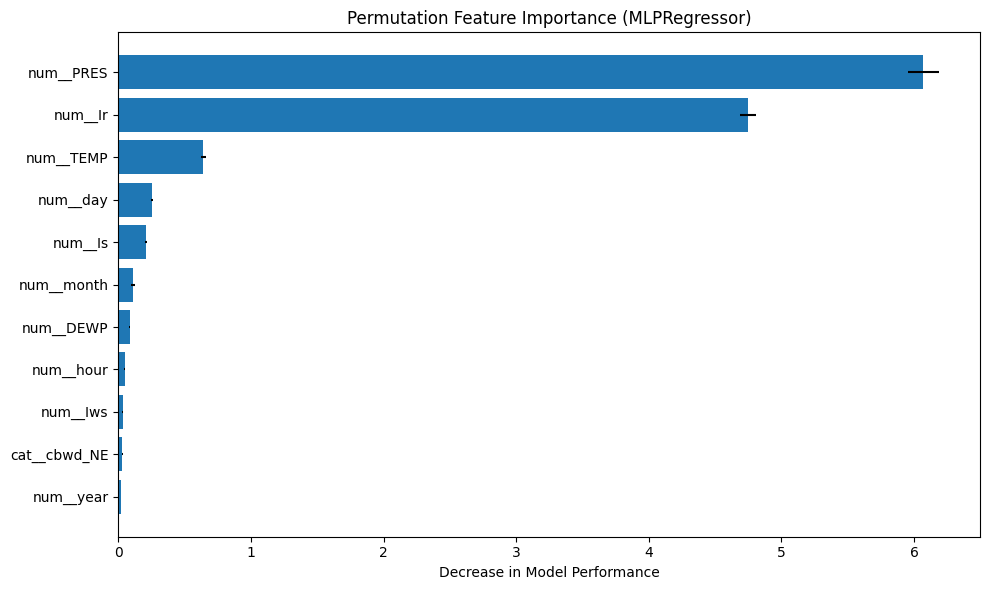

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Get fitted model
model = nn_pipeline.named_steps['regressor']

# Run permutation importance on the full pipeline
result = permutation_importance(nn_pipeline, X_test, y_test.values.ravel(), n_repeats=10, random_state=42, n_jobs=-1)

# Extract feature names from preprocessor
feature_names = nn_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Sort importances
sorted_idx = result.importances_mean.argsort()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.title("Permutation Feature Importance (MLPRegressor)")
plt.xlabel("Decrease in Model Performance")
plt.tight_layout()
plt.show()


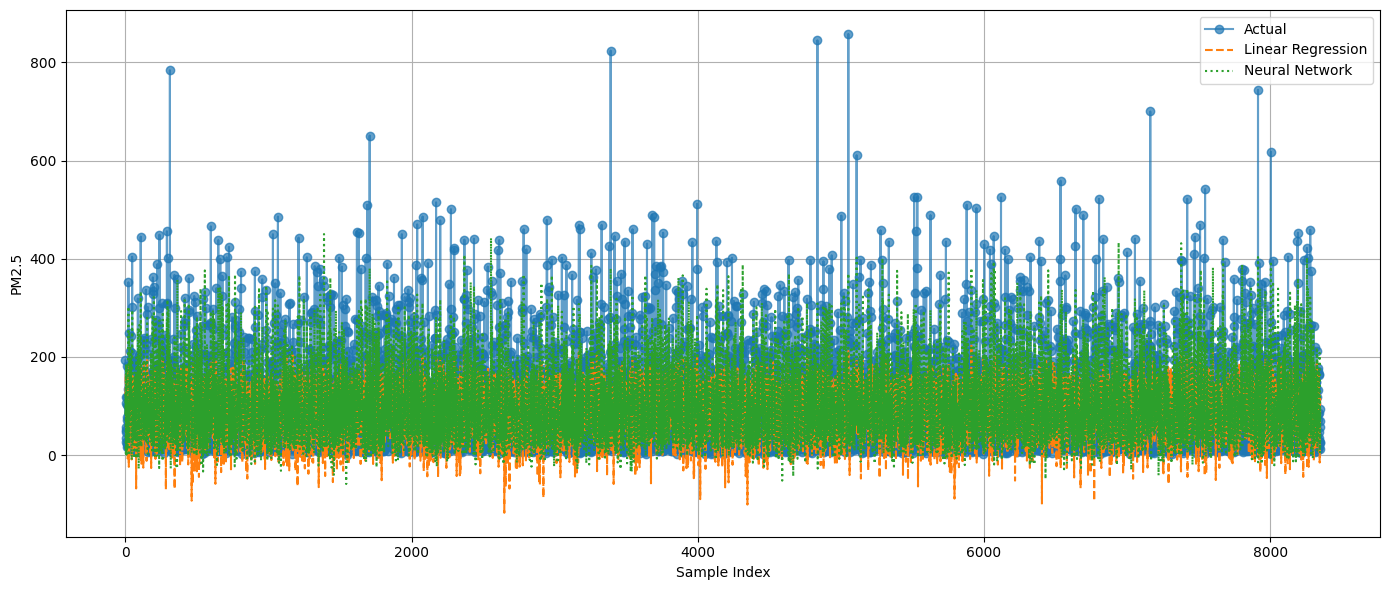

In [ ]:
# 11. Plot predictions vs actual
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred_lr, label='Linear Regression', linestyle='--')
plt.plot(y_pred_nn, label='Neural Network', linestyle=':')

plt.ylabel("PM2.5")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

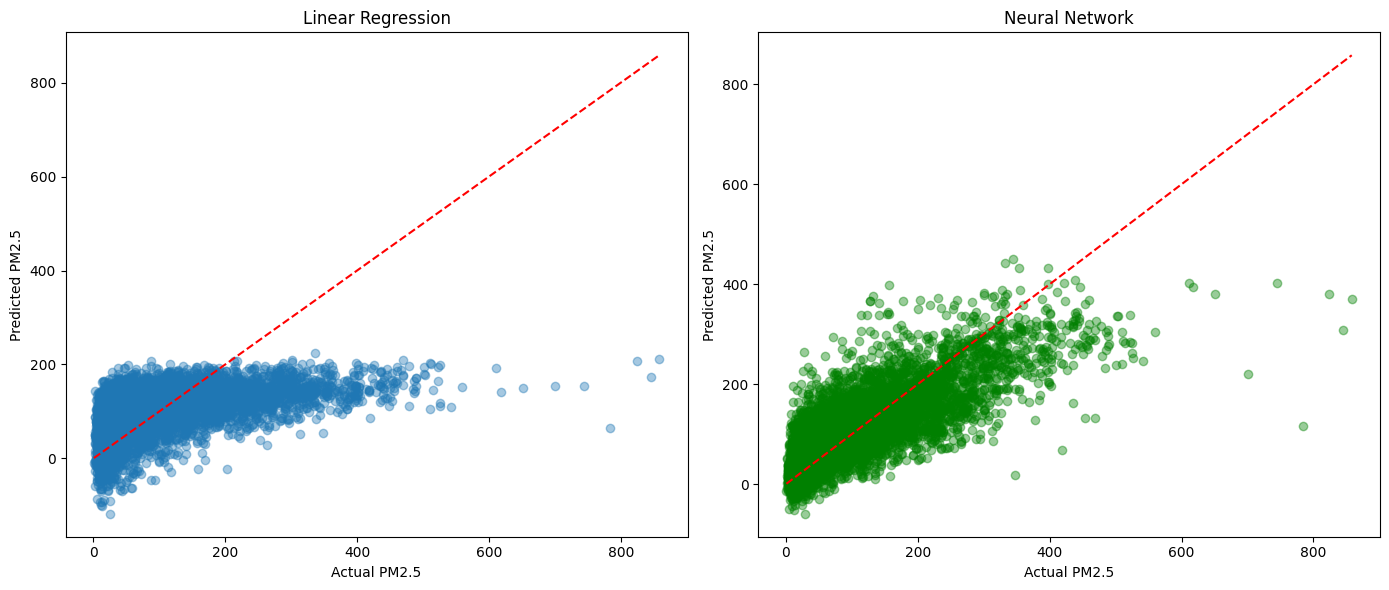

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure arrays are aligned and flattened
y_true = y_test.values.ravel()
y_pred_lr = np.array(y_pred_lr).ravel()
y_pred_nn = np.array(y_pred_nn).ravel()

min_len = min(len(y_true), len(y_pred_lr), len(y_pred_nn))
y_true = y_true[:min_len]
y_pred_lr = y_pred_lr[:min_len]
y_pred_nn = y_pred_nn[:min_len]

# Plot and save
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred_lr, alpha=0.4)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Linear Regression')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_nn, alpha=0.4, color='green')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Neural Network')
plt.grid(False)

plt.tight_layout()
plt.savefig("scatter_comparison_pm25.png", transparent=True, dpi=300)
plt.show()




---

### 🧭 What You're Seeing

#### 🔹 **Left Plot: Linear Regression**
- **Flattened predictions**: After ~200 µg/m³, the model **stops increasing predictions**, even though actual PM2.5 keeps rising.
- This is a sign of **underfitting** — linear regression **can't capture the nonlinear escalation** of PM2.5 during pollution spikes.
- Many points fall **below** the red dashed line → it **underpredicts high PM2.5** values.

#### 🔸 **Right Plot: Neural Network**
- Predictions follow the diagonal **more closely**, even at higher concentrations.
- Neural network is **nonlinear**, so it can better model:
  - Sudden spikes (like rush hour, industrial activity)
  - Saturation patterns (plateaus or curved effects)
- Still not perfect, but a **noticeable improvement** in fitting extremes.

---

### 📉 What the Red Line Means
That red dashed line is the **ideal line**:  
> If predictions = actual, all points fall on this line.

- Deviation from the line = **model error**
- The **more scattered** the points are from it → the **worse the predictions**

---

### ✅ Final Takeaways

| Model | Strengths | Weaknesses | Verdict |
|-------|-----------|------------|---------|
| **Linear Regression** | Fast, interpretable | Can’t capture complex pollution dynamics | Underfits |
| **Neural Network** | Flexible, models complex effects | Needs more tuning/data | Better fit |

Neural networks **learn nonlinear interactions** (e.g., between temperature, wind, dew point, pressure) — something linear regression just **can’t do** without manual feature engineering.



In [ ]:
# Install if needed
!pip install ucimlrepo tensorflow --quiet

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = fetch_ucirepo(id=381)
X = df.data.features
y = df.data.targets['pm2.5']

# Drop NA and align
X = X.loc[y.dropna().index]
y = y.dropna()

# Feature prep
categorical_features = ['cbwd']
numerical_features = X.columns.difference(categorical_features)

# Preprocessing pipeline
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)
y = y.values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Build improved MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=128, callbacks=[early_stop], verbose=1)

# Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 MLP Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 10600.0723 - mae: 70.9111 - val_loss: 8225.0273 - val_mae: 57.7076
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4803.3091 - mae: 47.9800 - val_loss: 4825.8271 - val_mae: 45.1048
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4237.3481 - mae: 44.5512 - val_loss: 3610.4812 - val_mae: 40.6782
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4052.9382 - mae: 43.3205 - val_loss: 3493.5671 - val_mae: 39.8573
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3991.3953 - mae: 42.7768 - val_loss: 3197.5938 - val_mae: 39.1731
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3806.7834 - mae: 41.8378 - val_loss: 3113.9260 - val_mae: 37.9886
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3937.7424 - mae: 42.1046 - val_loss: 3108.0554 - val_mae: 37.7377
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3807.0110 - mae: 41.4943 - val_loss: 3147.7893 -

<ipython-input-56-16828564cb84>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


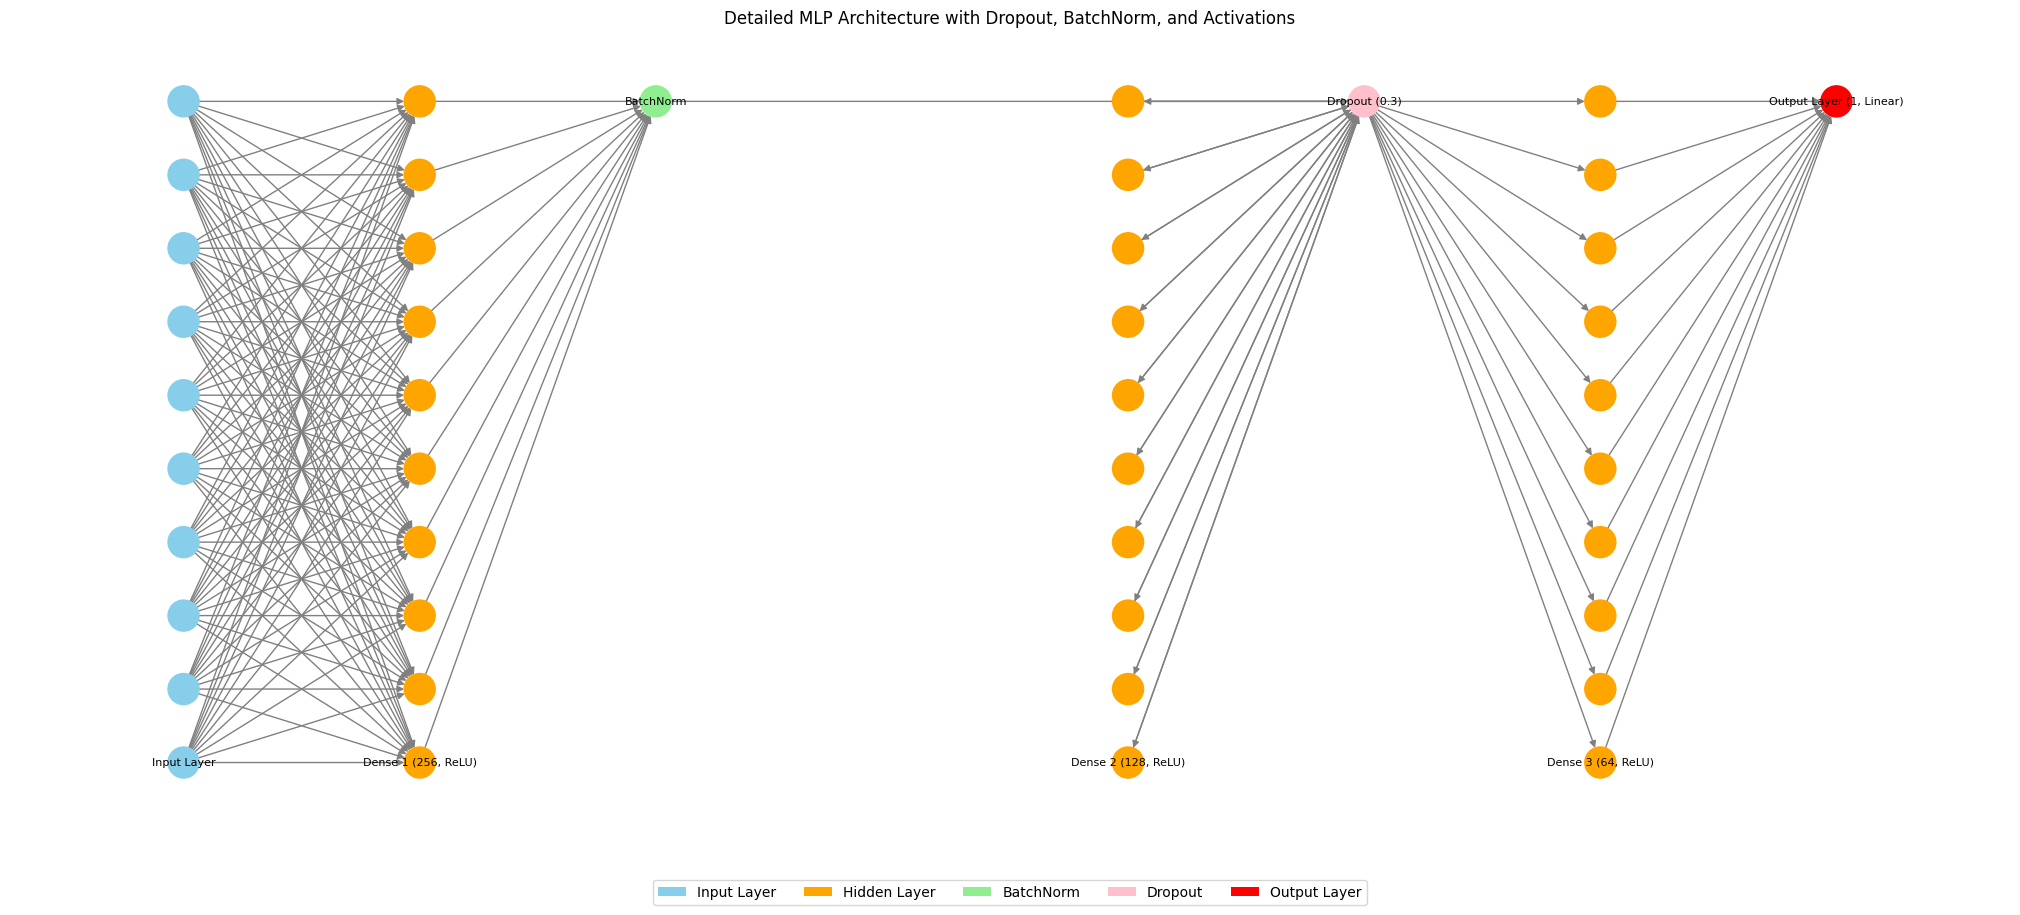

In [ ]:
# Recreate a similar styled diagram with all layers including Dropout, BatchNorm, etc.
# Use fewer nodes per layer for clarity and add a legend

layer_definitions = [
    ("Input Layer", 10, "skyblue"),
    ("Dense 1 (256, ReLU)", 10, "orange"),
    ("BatchNorm", 1, "lightgreen"),
    ("Dropout (0.3)", 1, "pink"),
    ("Dense 2 (128, ReLU)", 10, "orange"),
    ("Dropout (0.3)", 1, "pink"),
    ("Dense 3 (64, ReLU)", 10, "orange"),
    ("Output Layer (1, Linear)", 1, "red")
]

# Build the graph
G = nx.DiGraph()
positions = {}
node_colors = {}
labels = {}
x = 0

for name, num_nodes, color in layer_definitions:
    y_start = -(num_nodes - 1) / 2
    for i in range(num_nodes):
        node_id = f"{name}_{i}"
        G.add_node(node_id)
        positions[node_id] = (x, y_start + i * 0.5)
        node_colors[node_id] = color
        if i == 0:
            labels[node_id] = name
    x += 2

# Connect layers
for i in range(len(layer_definitions) - 1):
    src_name, src_count, _ = layer_definitions[i]
    dst_name, dst_count, _ = layer_definitions[i + 1]
    for a in range(src_count):
        for b in range(dst_count):
            G.add_edge(f"{src_name}_{a}", f"{dst_name}_{b}")

# Create color map for legend
legend_colors = {
    "Input Layer": "skyblue",
    "Hidden Layer": "orange",
    "BatchNorm": "lightgreen",
    "Dropout": "pink",
    "Output Layer": "red"
}

# Draw the graph
plt.figure(figsize=(20, 8))
nx.draw(G, pos=positions,
        node_color=[node_colors[n] for n in G.nodes],
        with_labels=False, node_size=500, edge_color="gray")

nx.draw_networkx_labels(G, pos=positions, labels=labels, font_size=8)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) for label, color in legend_colors.items()]
plt.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1))
plt.title("Detailed MLP Architecture with Dropout, BatchNorm, and Activations")
plt.axis('off')
plt.tight_layout()
plt.savefig("full_mlp_architecture_colored.png", transparent=True, dpi=300)
plt.show()
